### Setup and Imports

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

### Hyperparameters

In [82]:
NUM_EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 3e-4
Z_DIM = 10

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Building Dataloader

In [83]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.MNIST("./data", transform=image_transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

### Building AutoEncoder

In [84]:
class AutoEncoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, z_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 28*28),
            nn.Tanh(),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [86]:
model = AutoEncoder(Z_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

### Train AutoEncoder

In [87]:
def train(dataloader, model, optimizer, criterion):
    for epoch in range(NUM_EPOCHS):

        model.zero_grad()
        pbar = tqdm(dataloader, total=len(dataloader), position=0, desc="Training: ")
        for idx, data in enumerate(pbar):
            model.train()

            image, _ = data
            image = image.view(image.size(0), -1)
            image = image.to(DEVICE)

            with torch.set_grad_enabled(True):
                output = model(image)
            loss = criterion(output, image)

            pbar.set_description(
                "[Training] [Epoch %d/%d] [Batch %d/%d] [loss: %.4f]"
                % (epoch + 1, NUM_EPOCHS, idx, len(dataloader), loss.item())
            )

            loss.backward()
            optimizer.step()

            model.zero_grad()

In [88]:
train(dataloader, model, optimizer, criterion)

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

### Sample and display images

In [89]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

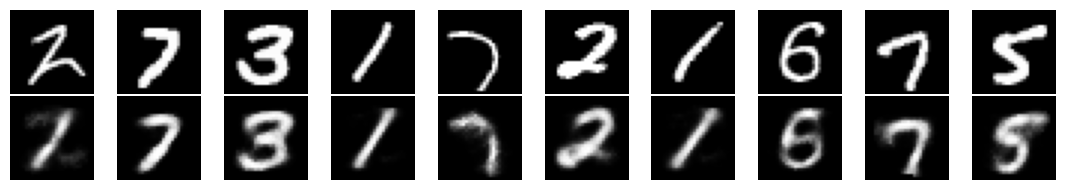

In [90]:
images, labels = next(iter(dataloader))
images_flattened = images.view(images.size(0), -1)
images_flattened = images_flattened.to(DEVICE)
outputs = model(images_flattened)

# Display
grid_col = 10
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1, grid_row))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,0,:,:], cmap='gray')
        axarr[row,col].axis('off')
        axarr[row+1,col].imshow(to_img(outputs)[i,0,:,:].cpu().detach().numpy(), cmap='gray')
        axarr[row+1,col].axis('off')        
        i += 1
f.tight_layout(h_pad=0.2, w_pad=0.1)        
plt.show()

### Set z_dim = 2, to look at latent variables

In [91]:
Z_DIM = 2
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

model_2 = AutoEncoder(z_dim=Z_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

train(dataloader, model_2, optimizer, criterion)

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

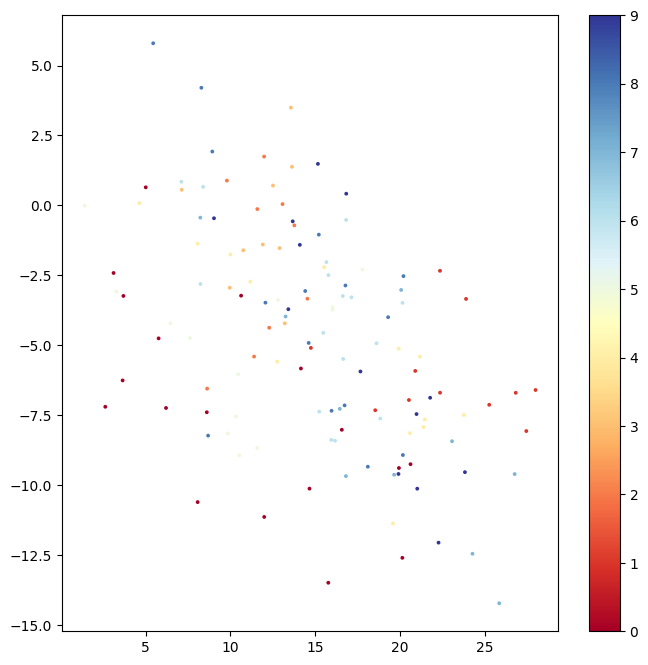

In [94]:
images, labels = next(iter(dataloader))
images_flattened = images.view(images.size(0), -1)
images_flattened = images_flattened.to(DEVICE)
outputs = model.encoder(images_flattened)
outputs = outputs.cpu().detach().numpy()


plt.figure(figsize=(8,8))
plt.scatter(outputs[:,0], outputs[:,1], c=labels, cmap='RdYlBu', s=3)
plt.colorbar()